<a href="https://colab.research.google.com/github/moon0825/ML-DL/blob/main/Yoga_Poses_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy
!pip install opencv-python
!pip install tqdm
!pip install mediapipe
#media-pipe 0.8.11

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 31.5 MB 1.2 MB/s 


In [ ]:
!pip install pycaret==2.3.10

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320 kB 4.1 MB/s 
     |████████████████████████████████| 16.9 MB 295 kB/s 
     |████████████████████████████████| 137 kB 68.6 MB/s 
     |████████████████████████████████| 167 kB 49.2 MB/s 
     |████████████████████████████████| 56 kB 4.4 MB/s 
     |████████████████████████████████| 1.3 MB 61.4 MB/s 
     |████████████████████████████████| 2.0 MB 57.4 MB/s 
     |████████████████████████████████| 88 kB 6.7 MB/s 
     |████████████████████████████████| 10.4 MB 29.5 MB/s 
     |████████████████████████████████| 3.3 MB 33.5 MB/s 
     |████████████████████████████████| 6.8 MB 42.3 MB/s 
     |████████████████████████████████| 636 kB 36.4 MB/s 
     |████████████████████████████████| 25.9 MB 906 kB/s 
     |████████████████████████████████| 268 kB 41.0 MB/s 
     |████████████████████████████████| 1.7 MB 31.9 MB/s 
  Installing build dependencies ...

In [ ]:
!pip install xgboost==1.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 193.7 MB 27 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [ ]:
!pip list

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_path = '/content/drive/MyDrive/프로젝트/Yoga-Poses'

In [ ]:
yoga_path = drive_path + '/archive.zip'
!cp "$yoga_path" .
!unzip 'archive.zip'

In [ ]:
#드라이브에 저장했던 csv파일 로드
yoga_train_path = drive_path + '/fitness_poses_csvs_out_basic.csv'
!cp "$yoga_train_path" .

yoga_test_path = drive_path + '/fitness_poses_csvs_out_TEST.csv'
!cp "$yoga_test_path" .

In [ ]:
# Folder with images to use as target poses for classification.
#
# Images should repesent terminal states of desired pose classes.
images_in_folder = '/content/DATASET/TRAIN'

# Output folders for bootstrapped images and CSVs. Image will have a predicted
# Pose rendering and can be used to remove unwanted samples.
images_out_folder = 'fitness_poses_images_out_basic'

# Output CSV path to put bootstrapped poses to. This CSV will be used by the
# demo App.
#
# Output CSV format:
#   sample_00001,pose_class_1,x1,y1,z1,x2,y2,z2,...,x33,y33,z33
#   sample_00002,pose_class_2,x1,y1,z1,x2,y2,z2,...,x33,y33,z33
#   ...
#
csv_out_path = 'fitness_poses_csvs_out_basic.csv'

In [ ]:
import mediapipe as mp
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

help(mp_pose.Pose)

Help on class Pose in module mediapipe.python.solutions.pose:

class Pose(mediapipe.python.solution_base.SolutionBase)
 |  Pose(static_image_mode=False, model_complexity=1, smooth_landmarks=True, enable_segmentation=False, smooth_segmentation=True, min_detection_confidence=0.5, min_tracking_confidence=0.5)
 |  
 |  MediaPipe Pose.
 |  
 |  MediaPipe Pose processes an RGB image and returns pose landmarks on the most
 |  prominent person detected.
 |  
 |  Please refer to https://solutions.mediapipe.dev/pose#python-solution-api for
 |  usage examples.
 |  
 |  Method resolution order:
 |      Pose
 |      mediapipe.python.solution_base.SolutionBase
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, static_image_mode=False, model_complexity=1, smooth_landmarks=True, enable_segmentation=False, smooth_segmentation=True, min_detection_confidence=0.5, min_tracking_confidence=0.5)
 |      Initializes a MediaPipe Pose object.
 |      
 |      Args:
 |        static_i

In [ ]:
import csv
import cv2
import numpy as np
import os
import sys
import tqdm

from mediapipe.python.solutions import drawing_utils as mp_drawing
from mediapipe.python.solutions import pose as mp_pose


with open(csv_out_path, 'w') as csv_out_file:
  csv_out_writer = csv.writer(csv_out_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)

  # Folder names are used as pose class names.
  pose_class_names = sorted([n for n in os.listdir(images_in_folder) if not n.startswith('.')])

  for pose_class_name in pose_class_names:
    print('Bootstrapping ', pose_class_name, file=sys.stderr)

    if not os.path.exists(os.path.join(images_out_folder, pose_class_name)):
      os.makedirs(os.path.join(images_out_folder, pose_class_name))

    image_names = sorted([
        n for n in os.listdir(os.path.join(images_in_folder, pose_class_name))
        if not n.startswith('.')])
    for image_name in tqdm.tqdm(image_names, position=0):
      # Load image. 함수화 시키기
      input_frame = cv2.imread(os.path.join(images_in_folder, pose_class_name, image_name))
      input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)

      # Initialize fresh pose tracker and run it.
      with mp_pose.Pose(
              static_image_mode=True,
              model_complexity=2,
              enable_segmentation=True,
              min_detection_confidence=0.5) as pose_tracker:
        result = pose_tracker.process(image=input_frame)
        pose_landmarks = result.pose_landmarks
      # Save image with pose prediction (if pose was detected).
      output_frame = input_frame.copy()
      if pose_landmarks is not None:
        mp_drawing.draw_landmarks(
            image=output_frame,
            landmark_list=pose_landmarks,
            connections=mp_pose.POSE_CONNECTIONS)
      output_frame = cv2.cvtColor(output_frame, cv2.COLOR_RGB2BGR)
      cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)
      
      # Save landmarks.
      if pose_landmarks is not None:
        # Check the number of landmarks and take pose landmarks.
        assert len(pose_landmarks.landmark) == 33, 'Unexpected number of predicted pose landmarks: {}'.format(len(pose_landmarks.landmark))
        pose_landmarks = [[lmk.x, lmk.y, lmk.z] for lmk in pose_landmarks.landmark]

        # Map pose landmarks from [0, 1] range to absolute coordinates to get
        # correct aspect ratio.
        frame_height, frame_width = output_frame.shape[:2]
        pose_landmarks *= np.array([frame_width, frame_height, frame_width])

        # Write pose sample to CSV.
        pose_landmarks = np.around(pose_landmarks, 5).flatten().astype(np.str).tolist()
        csv_out_writer.writerow([image_name, pose_class_name] + pose_landmarks)
        #바로 모델에 넣기
        #1. test 폴더에 있는 이미지 스켈레톤 추출
        #2. 학습된 모델로 예측, 정확도 출력
        #2-5 딥러닝 tf.dataset변환 후 학습
        #3. 예외 선별이 안되어있음
        #4. kaggle에 올려보기~~~~~~~~~~
        #5 LSTM을 이용해 연속된 동작 비교하기
        #댄스 챌린지

Bootstrapping  downdog
  0%|          | 0/97 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 97/97 [00:43<00:00,  2.22it/s]
Bootstrapping  goddess
100%|██████████| 80/80 [00:34<00:00,  2.31it/s]
Bootstrapping  plank
100%|██████████| 115/115 [00:55<00:00,  2.07it/s]
Bootstrapping  tree
100%|██████████| 69/69 [00:36<00:00,  1.87it/s]
Bootstrapping  warrior2
100%|██████████| 109/109 [00:48<00:00,  2.25it/s]


In [ ]:

!cp "./fitness_poses_csvs_out_basic.csv" "$drive_path"
!cp -r "fitness_poses_images_out_basic" "$drive_path"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection, preprocessing

# Pycaret 활용하기

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycaret.classification import *

In [ ]:
yp_df = pd.read_csv("fitness_poses_csvs_out_basic.csv",header=None)
yp_df = yp_df.rename(columns={0:'name', 1:'pose'})

In [ ]:
yp_data_df = yp_df.drop(['name'], axis=1)

In [ ]:
yp_data_df

,pose,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,downdog,371.84716,390.31965,0.21649,353.48891,397.38871,-35.04172,351.19230,396.23137,-35.07444,348.65141,394.93967,-35.47355,353.54306,395.42561,10.02325,351.61605,393.56578,10.01890,349.85794,391.29428,9.94207,335.03216,373.72676,-124.27581,338.72945,369.91214,80.16163,373.42700,369.86860,-26.52352,374.17421,369.10240,32.15505,345.32721,304.61269,-171.60702,365.64542,297.01827,157.22747,256.81738,401.56354,-327.22788,257.54628,379.31132,242.56548,132.47830,475.80198,-292.55050,152.50711,456.67316,62.55357,89.36831,489.33166,-334.43180,118.51974,455.63729,59.48059,87.51370,480.23983,-307.48387,108.14079,464.85269,22.12932,106.34405,476.36211,-281.98220,123.15433,469.53174,44.03570,531.50452,70.55567,-142.02374,533.74959,81.32577,142.36260,650.52875,263.12159,-94.44541,631.91321,273.82029,157.91954,748.67208,435.75520,-74.07457,739.72308,429.88144,252.99074,781.18786,463.01777,-78.88233,770.89868,454.78140,256.17436,682.86334,504.75037,-184.41969,692.54956,495.99586,185.22864
1,downdog,254.07877,330.63487,-70.27736,238.84882,329.86177,-102.98070,237.89488,328.28179,-103.02631,236.81169,326.59172,-103.30559,238.33148,327.95184,-52.25347,237.22844,325.57226,-52.30331,236.29479,322.85755,-52.43320,233.83092,307.26354,-183.74821,234.79048,303.02743,49.03047,262.20553,317.24105,-96.84745,261.86147,316.02493,-29.81603,266.26588,265.93421,-259.32339,279.16297,261.22639,154.65963,198.37389,350.29212,-443.72260,206.46008,336.11623,244.77970,108.34461,411.72020,-442.51477,136.83478,395.35949,51.79264,73.77609,421.23872,-497.48437,114.47870,394.74267,56.48621,73.72954,411.28326,-459.39370,104.80911,397.06738,10.99814,89.79135,409.44381,-428.37620,114.68243,401.25544,30.15671,431.95659,101.53410,-157.93460,432.12153,109.17381,158.37887,517.95344,252.76795,-125.73585,512.97456,262.73255,179.67228,597.66941,388.30430,-85.92278,592.93770,383.09510,265.83074,626.41060,413.12577,-88.94678,618.76582,404.64583,269.45249,533.23314,441.15268,-190.42401,541.10219,440.10107,204.87353
2,downdog,495.17019,578.11415,-89.19945,464.72518,586.34573,-141.57816,461.12655,583.76085,-141.50859,457.25927,580.83952,-142.06654,466.08424,584.42571,-69.10110,463.85440,581.80639,-69.16910,461.97070,578.50092,-69.35077,438.20647,548.45649,-264.93140,446.56109,545.92952,70.05182,498.01115,548.57398,-125.12662,500.58589,549.71569,-28.36384,452.72734,456.21264,-312.92388,478.18165,451.43250,221.33730,318.68269,615.17954,-567.83077,348.08972,583.01736,388.00600,166.62469,730.66244,-504.08149,208.48124,688.40182,50.87211,114.64248,745.05404,-565.09455,165.84735,683.48787,65.53229,112.60056,728.72003,-504.29245,150.89278,695.61925,-13.38248,135.63058,725.30407,-476.94415,171.39015,703.23921,19.40109,792.73825,179.87921,-218.49495,790.13515,198.84417,218.64204,880.09965,470.01294,-187.73280,863.57117,494.19652,268.74248,1070.42685,659.03735,-65.91624,1035.92398,629.47047,485.76719,1119.24534,691.85107,-65.00646,1076.92137,654.00966,497.88408,984.62405,731.07570,-165.69968,984.10084,696.95009,455.01691
3,downdog,248.73156,190.51706,-34.93128,244.43396,199.66024,-60.71437,245.88769,200.60341,-60.66525,247.11165,201.36054,-60.76151,240.97023,196.25168,-47.54139,239.39893,194.97703,-47.50776,237.95399,193.57629,-47.70352,246.04386,191.36956,-140.74653,234.07322,182.90291,-83.71919,253.61504,181.56800,-61.37306,249.34127,178.78131,-47.34443,260.93560,143.97185,-203.52971,224.11013,128.90625,-57.64452,205.11927,220.57768,-289.82526,152.84657,181.49522,-68.64172,146.08864,274.67861,-408.25625,83.44637,226.73647,-122.74804,136.70711,286.70863,-462.63210,56.75057,224.30400,-142.28532,118.36615,280.33913,-464.63078,60.16597,232.92358,-180.21425,121.13540,276.86965,-416.02423,78.42745,237.65

In [ ]:
model = setup(data=yp_data_df, 
              target='pose', 
              train_size=0.7, # default value
              session_id=9,
              use_gpu=True) # Random seed

# Pycaret을 활용한 최적 모델
|index|Model|Accuracy|AUC|Recall|Prec\.|F1|Kappa|MCC|TT \(Sec\)|
|---|---|---|---|---|---|---|---|---|---|
|lightgbm|Light Gradient Boosting Machine|0\.8682|0\.9775|0\.8653|0\.8785|0\.8664|0\.8334|0\.8365|1\.058|
|xgboost|Extreme Gradient Boosting|0\.8529|0\.9764|0\.849|0\.8637|0\.8505|0\.814|0\.8174|2\.197|
|et|Extra Trees Classifier|0\.8433|0\.9666|0\.8374|0\.8494|0\.8415|0\.8017|0\.8041|1\.067|
|lr|Logistic Regression|0\.8404|0\.9463|0\.8399|0\.8489|0\.8391|0\.7989|0\.8015|2\.239|
|rf|Random Forest Classifier|0\.8239|0\.9641|0\.817|0\.8314|0\.821|0\.7771|0\.7802|1\.016|
|gbc|Gradient Boosting Classifier|0\.8182|0\.9619|0\.811|0\.8287|0\.8163|0\.7699|0\.7728|4\.225|
|knn|K Neighbors Classifier|0\.7628|0\.9375|0\.7626|0\.7725|0\.7636|0\.7016|0\.7034|0\.421|
|svm|SVM - Linear Kernel|0\.7365|0\.0|0\.7345|0\.7828|0\.7297|0\.6681|0\.681|0\.117|
|dt|Decision Tree Classifier|0\.7198|0\.8216|0\.7133|0\.7307|0\.7182|0\.6451|0\.6481|0\.04|
|ridge|Ridge Classifier|0\.6893|0\.0|0\.6856|0\.697|0\.6874|0\.6062|0\.6086|0\.059|
|lda|Linear Discriminant Analysis|0\.5686|0\.8167|0\.5569|0\.5807|0\.5673|0\.4539|0\.4564|0\.201|
|ada|Ada Boost Classifier|0\.5547|0\.7834|0\.5492|0\.59|0\.5567|0\.4358|0\.4416|0\.282|
|qda|Quadratic Discriminant Analysis|0\.5437|0\.7089|0\.5263|0\.5603|0\.5283|0\.4194|0\.4285|0\.08|
|dummy|Dummy Classifier|0\.2538|0\.5|0\.2|0\.0645|0\.1028|0\.0|0\.0|0\.01|
|nb|Naive Bayes|0\.086|0\.3544|0\.1112|0\.0368|0\.0508|-0\.1221|-0\.1292|0\.024|

In [ ]:
top_3_models = compare_models(sort='Accuracy', # Other options are 'AUC', 'Recall', 'Precision', 'F1', 'Kappa' and 'MCC'
                              n_select = 3) # Select top n models 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.8821,0.9583,0.8767,0.8963,0.8824,0.8502,0.8540,0.022
lightgbm,Light Gradient Boosting Machine,0.8585,0.9751,0.8548,0.8680,0.8571,0.8209,0.8238,1.064
et,Extra Trees Classifier,0.8474,0.9705,0.8407,0.8555,0.8458,0.8068,0.8094,0.831
xgboost,Extreme Gradient Boosting,0.8446,0.9727,0.8416,0.8561,0.8428,0.8034,0.8067,0.747
gbc,Gradient Boosting Classifier,0.8418,0.9690,0.8357,0.8575,0.8401,0.7994,0.8042,3.445
rf,Random Forest Classifier,0.8335,0.9657,0.8275,0.8442,0.8317,0.7891,0.7925,0.887
lr,Logistic Regression,0.8321,0.9436,0.8302,0.8410,0.8315,0.7883,0.7906,0.527
ridge,Ridge Classifier,0.8141,0.0000,0.8109,0.8200,0.8122,0.7651,0.7673,0.013
lda,Linear Discriminant Analysis,0.8058,0.9355,0.8010,0.8129,0.8045,0.7547,0.7570,0.023
knn,K Neighbors Classifier,0.7642,0.9320,0.7635,0.7710,0.7637,0.7030,0.7048,0.148


INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 2
INFO:logs:[QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001), LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=9, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0), ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                   

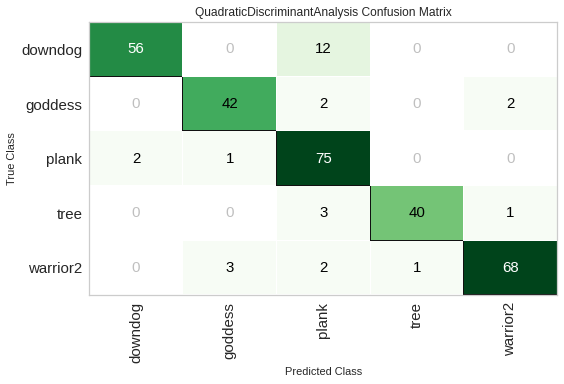

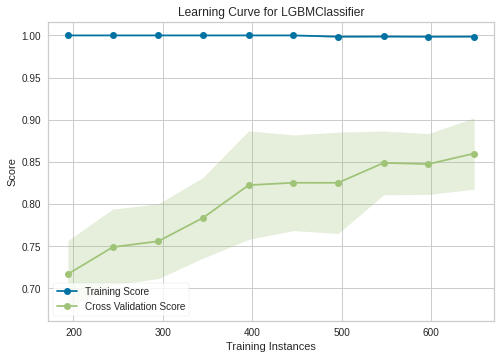

In [ ]:
evaluate_model(top_3_models[0])

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [ ]:
predict_model(top_3_models[0])

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Quadratic Discriminant Analysis,0.9065,0.9761,0.9052,0.9151,0.9074,0.8812,0.8834


,13,25,28,35,36,37,38,39,40,41,...,86,93,94,95,97,98,100,pose,Label,Score
0,-26.605101,29.871450,-108.996948,397.081177,215.079895,124.692299,403.224945,216.773697,-177.819321,387.241150,...,99.991417,319.757843,-7.780700,119.600281,135.856583,104.943329,-92.527657,plank,plank,1.0
1,-108.366951,-100.976730,-32.422451,332.347900,225.561905,-83.148369,312.467285,180.576584,-23.873350,343.011261,...,176.555466,369.963593,20.923960,423.600220,-137.926575,154.441437,-38.137180,warrior2,warrior2,1.0
2,-134.633057,-37.578690,-47.932640,268.055634,135.392212,47.456322,184.380249,131.280380,-13.253950,305.364990,...,134.922714,498.889618,-142.121307,345.814819,433.388672,103.169312,-257.542419,warrior2,warrior2,1.0
3,-81.680862,46.292789,21.061560,242.173706,135.799286,135.136597,204.825211,243.963837,35.342751,324.576630,...,688.256287,349.902863,-80.058517,759.307434,-121.958298,739.737915,-236.811798,plank,plank,1.0
4,-124.557007,-237.598297,39.755939,364.590942,570.257446,-363.741486,393.996490,552.644531,266.575409,376.161835,...,1140.880737,843.777161,353.093750,1146.138184,-238.570709,1120.356201,236.619965,plank,plank,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,-47.308430,-110.080040,35.305450,330.876068,201.466492,-160.477188,334.720551,203.469910,97.621452,291.641174,...,576.386353,297.298950,150.129868,569.446411,-179.765137,549.856384,101.567551,downdog,downdog,1.0
306,-154.892059,-159.794617,-30.701891,558.004333,251.565460,-116.402206,461.312012,248.151703,30.214630,656.482056,...,394.134949,628.946289,-11.698090,796.355530,-210.504303,325.877686,-80.616074,warrior2,warrior2,1.0
307,-115.966431,-135.721069,142.272125,715.649963,252.194153,-186.011353,566.076172,262.010498,243.457153,902.513733,...,1109.870117,934.486084,141.665253,272.531189,-179.531143,1121.538452,-39.869610,warrior2,warrior2,1.0
308,-165.719437,-120.297028,-94.728256,128.367645,145.717285,-77.106758,123.708717,209.477539,-57.899632,182.582855,...,351.299225,289.126556,33.494659,300.115448,226.575607,380.680969,-16.996180,plank,plank,1.0


# 블렌딩

In [ ]:
blended = blend_models(estimator_list=top_3_models, 
                       fold=10, # default
                       optimize='Accuracy',
                       method = 'hard')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9041,0.0,0.9020,0.9120,0.9021,0.8784,0.8808
1,0.8889,0.0,0.8922,0.8914,0.8877,0.8598,0.8610
2,0.9028,0.0,0.9024,0.9061,0.9026,0.8768,0.8775
3,0.8611,0.0,0.8464,0.8643,0.8569,0.8237,0.8268
4,0.8472,0.0,0.8371,0.8628,0.8490,0.8067,0.8099
5,0.9306,0.0,0.9287,0.9418,0.9306,0.9122,0.9153
6,0.8472,0.0,0.8410,0.8698,0.8503,0.8061,0.8111
7,0.8750,0.0,0.8602,0.8935,0.8709,0.8411,0.8468
8,0.9028,0.0,0.9068,0.9037,0.9005,0.8776,0.8790


INFO:logs:create_model_container: 16
INFO:logs:master_model_container: 16
INFO:logs:display_container: 4
INFO:logs:VotingClassifier(estimators=[('qda',
                              QuadraticDiscriminantAnalysis(priors=None,
                                                            reg_param=0.0,
                                                            store_covariance=False,
                                                            tol=0.0001)),
                             ('lightgbm',
                              LGBMClassifier(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=-1,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                  

In [ ]:
final_blended = finalize_model(blended)
print(final_blended)

In [ ]:
predict_model(final_blended)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=VotingClassifier(estimators=[('qda',
                              QuadraticDiscriminantAnalysis(priors=None,
                                                            reg_param=0.0,
                                                            store_covariance=False,
                                                            tol=0.0001)),
                             ('lightgbm',
                              LGBMClassifier(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=-1,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,1.0,0,1.0,1.0,1.0,1.0,1.0


,13,25,28,35,36,37,38,39,40,41,...,85,86,93,94,95,97,98,100,pose,Label
0,-26.605101,29.871450,-108.996948,397.081177,215.079895,124.692299,403.224945,216.773697,-177.819321,387.241150,...,195.107269,99.991417,319.757843,-7.780700,119.600281,135.856583,104.943329,-92.527657,plank,plank
1,-108.366951,-100.976730,-32.422451,332.347900,225.561905,-83.148369,312.467285,180.576584,-23.873350,343.011261,...,-76.401314,176.555466,369.963593,20.923960,423.600220,-137.926575,154.441437,-38.137180,warrior2,warrior2
2,-134.633057,-37.578690,-47.932640,268.055634,135.392212,47.456322,184.380249,131.280380,-13.253950,305.364990,...,449.891754,134.922714,498.889618,-142.121307,345.814819,433.388672,103.169312,-257.542419,warrior2,warrior2
3,-81.680862,46.292789,21.061560,242.173706,135.799286,135.136597,204.825211,243.963837,35.342751,324.576630,...,24.673090,688.256287,349.902863,-80.058517,759.307434,-121.958298,739.737915,-236.811798,plank,plank
4,-124.557007,-237.598297,39.755939,364.590942,570.257446,-363.741486,393.996490,552.644531,266.575409,376.161835,...,-54.495930,1140.880737,843.777161,353.093750,1146.138184,-238.570709,1120.356201,236.619965,plank,plank
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,-47.308430,-110.080040,35.305450,330.876068,201.466492,-160.477188,334.720551,203.469910,97.621452,291.641174,...,-108.171829,576.386353,297.298950,150.129868,569.446411,-179.765137,549.856384,101.567551,downdog,downdog
306,-154.892059,-159.794617,-30.701891,558.004333,251.565460,-116.402206,461.312012,248.151703,30.214630,656.482056,...,-85.390343,394.134949,628.946289,-11.698090,796.355530,-210.504303,325.877686,-80.616074,warrior2,warrior2
307,-115.966431,-135.721069,142.272125,715.649963,252.194153,-186.011353,566.076172,262.010498,243.457153,902.513733,...,-39.360710,1109.870117,934.486084,141.665253,272.531189,-179.531143,1121.538452,-39.869610,warrior2,warrior2
308,-165.719437,-120.297028,-94.728256,128.367645,145.717285,-77.106758,123.708717,209.477539,-57.899632,182.582855,...,205.869171,351.299225,289.126556,33.494659,300.115448,226.575607,380.680969,-16.996180,plank,plank


In [ ]:
holdout_data = yp_df.sample(frac=0.10, random_state=0).reset_index(drop=True)

unseen_predictions = predict_model(final_blended, data=holdout_data)
unseen_predictions

In [ ]:
save_model(final_blended, 'final_blended')

In [ ]:
!cp "./final_blended.pkl" "$drive_path"

In [ ]:

from google.colab import files
#files.download('final_blended.pkl')

In [ ]:
from pycaret.classification import load_model
yoga_model_path = drive_path + '/final_blended.pkl'
yoga_path = drive_path + '/fitness_poses_csvs_out_TEST.csv'
!cp "$yoga_path" .
!cp "$yoga_model_path" .


In [ ]:
loaded_model = load_model('final_blended')

INFO:logs:Initializing load_model()
INFO:logs:load_model(model_name=final_blended, platform=None, authentication=None, verbose=True)


Transformation Pipeline and Model Successfully Loaded


In [ ]:
yoga_path = drive_path + '/fitness_poses_csvs_out_TEST.csv'
!cp "$yoga_path" .

In [ ]:
yp_df = pd.read_csv("fitness_poses_csvs_out_TEST.csv",header=None)
yp_df = yp_df.rename(columns={0:'name', 1:'pose'})
yp_data_df = yp_df.drop(['name'], axis=1)

holdout_data = yp_data_df.sample(frac=0.10, random_state=0).reset_index(drop=True)

unseen_predictions = predict_model(loaded_model, data=holdout_data)
unseen_predictions

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='pose',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strateg...
                                                                    max_features='auto',
                                                                    max_leaf_nodes=None,
                                    

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.0,0,0,0,0,0,0


,pose,2,3,4,5,6,7,8,9,10,...,92,93,94,95,96,97,98,99,100,Label
0,warrior2,289.10764,298.86796,-324.58974,299.09768,288.93527,-323.92023,302.31647,289.22807,-323.83075,...,180.42670,713.55400,-37.02218,527.60553,712.14043,-181.14672,129.58809,709.36019,-174.15847,warrior2
1,warrior2,387.13137,211.11146,-116.16753,393.03626,203.37594,-122.85592,394.74286,203.36498,-122.83884,...,317.14734,521.41602,-0.73571,588.13179,525.14751,-135.83034,270.94367,529.31646,-69.87147,warrior2
2,warrior2,291.71932,368.83785,-395.57914,300.03720,355.93498,-393.99858,304.20409,355.34217,-393.92163,...,213.76938,792.96537,-15.29676,623.82644,837.22483,-184.35501,143.75510,813.70505,-103.03516,warrior2
3,goddess,383.32069,93.12066,-264.44943,384.87644,81.01207,-241.25602,389.23266,79.64530,-241.17208,...,215.38756,288.97642,94.48005,712.21094,376.22426,-82.34307,199.41728,252.15476,106.86054,goddess
4,plank,87.05502,130.28840,-90.16057,77.13918,115.20841,-80.01952,79.72327,109.56828,-79.97329,...,578.01946,254.96236,129.36243,653.24426,281.14057,-2.67898,639.73914,269.44254,96.34329,plank
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,plank,519.20470,212.34881,-166.61441,522.12322,199.67563,-151.85187,521.95290,198.46672,-151.80490,...,56.49639,227.66595,293.29089,78.13001,297.44597,414.96094,58.97783,274.17439,256.16956,plank
99,plank,361.56373,188.66843,-52.69463,364.56735,180.15322,-47.43699,364.06420,179.02346,-47.37220,...,44.32137,280.04630,11.65175,77.72289,319.10712,97.24699,60.53360,319.50012,-56.31923,plank
100,plank,262.32480,441.62452,-88.60359,246.88396,422.01497,-131.83125,247.66150,418.08622,-131.90409,...,1233.78392,638.18774,327.58366,1177.20144,753.64819,-95.58577,1166.26584,742.03314,209.50907,plank
101,warrior2,259.51443,79.16710,-205.99234,267.14025,69.73179,-212.87008,269.46392,69.53799,-212.74452,...,218.63178,398.80534,32.54631,499.80042,399.46379,-116.79900,162.65497,415.07916,-24.42026,warrior2


In [ ]:
from pycaret.utils import check_metric
check_metric(unseen_predictions['pose'], unseen_predictions['Label'], metric = 'Accuracy')

1.0